#### Overview

In this notebook, we implement the experiment conducted by Gohr for distinguishing the random ciphertext from the real ciphertext.

- Class 0: random class
- Class 1: real class

The two messages selected for encryption are selected such that the difference between the two messages is delta. 

- P1 = N, Here, N is any random value or 16 bit integer
- P2 = N XOR diff

Further, the encryption of these messages is performed using SPECK32/64 cipher scheme, and the ciphertext generated is represented as binary for ML training.

The size of the input vector to ML classifier is 64 bits where the ciphertext of each message is represented using 2 words. Each word is 16-bits long that represents first and second half of Pi considered.

Input Vector = [w1, w2, w3, w4]; Here, w1, w2 represents P1, and w3, w4 represents P2
Labels = [0, 1]; 0 - random class, 1 - real class

In [1]:
import os
import sys
import datetime
sys.path.append("../utilities/")

from speckUtilities import *
from modelEvalUtilities import *
import numpy as np
import pandas as pd
from pickle import dump

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Dense, Conv1D, Input, Reshape, Permute, Add,
                                     Flatten, BatchNormalization, Activation)
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
from IPython.display import Image

%load_ext autotime

2024-03-18 14:54:14.219577: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# parameters for the experiment
num_rounds = "<num-of-rounds>" # number of rounds to be considered in SPECK32/64
depth = 10 # depth of the CNN model (number of Convolution layers)
num_epochs = 200 # number of epochs to be considered for model training
bs = 5000 # batch size for trainig the model

# path to save the trained models and other statistics
models_dir_path = "<path-to-save-trained-model>" # add path
models_dir_path = os.path.join(models_dir_path, "rounds-" + str(num_rounds))
os.makedirs(models_dir_path, exist_ok=True)

# path to save the generated dataset
dataset_dir_path = "<path-to-gohr's-random-vs-cipher-dataset>"
dataset_dir_path = os.path.join(dataset_dir_path, "rounds-" + str(num_rounds))
os.makedirs(dataset_dir_path, exist_ok=True)

# path to save the statistics on the training, validation, and testing datasets
statistics_dir_path = "<path-to-save-results>"
statistics_dir_path = os.path.join(statistics_dir_path, "rounds-" + str(num_rounds))
os.makedirs(statistics_dir_path, exist_ok=True)

time: 3.59 ms


##### Utility functions for training the model

In [3]:
def cyclic_lr(num_epochs, high_lr, low_lr):
    res = lambda i: low_lr + ((num_epochs-1) - i % num_epochs)/(num_epochs-1) * (high_lr - low_lr)
    return res


def make_checkpoint(datei):
    res = ModelCheckpoint(datei, monitor='val_loss', save_best_only = True)
    return res

# make residual tower of convolutional blocks
def make_resnet(num_blocks=2, num_filters=32, num_outputs=1, d1=64, d2=64, word_size=16, ks=3,depth=5,
                reg_param=0.0001, final_activation='sigmoid'):
    # input and preprocessing layers
    inp = Input(shape=(num_blocks * word_size * 2,))
    rs = Reshape((2 * num_blocks, word_size))(inp)
    perm = Permute((2, 1))(rs)

    # add a single residual layer that will expand the data to num_filters channels this is a bit-sliced layer
    conv0 = Conv1D(num_filters, kernel_size=1, padding='same', kernel_regularizer=l2(reg_param))(perm)
    conv0 = BatchNormalization()(conv0)
    conv0 = Activation('relu')(conv0)

    # add residual blocks
    shortcut = conv0

    for i in range(depth):
        conv1 = Conv1D(num_filters, kernel_size=ks, padding='same', kernel_regularizer=l2(reg_param))(shortcut)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)
        conv2 = Conv1D(num_filters, kernel_size=ks, padding='same', kernel_regularizer=l2(reg_param))(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation('relu')(conv2)
        shortcut = Add()([shortcut, conv2])

    # add prediction head
    flat1 = Flatten()(shortcut)
    dense1 = Dense(d1, kernel_regularizer=l2(reg_param))(flat1)
    dense1 = BatchNormalization()(dense1)
    dense1 = Activation('relu')(dense1)
    dense2 = Dense(d2, kernel_regularizer=l2(reg_param))(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Activation('relu')(dense2)
    out = Dense(num_outputs, activation=final_activation, kernel_regularizer=l2(reg_param))(dense2)
    model = Model(inputs=inp, outputs=out)
    return (model)

time: 35.3 ms


##### Model Compilation and Training

In [4]:
# create the network
net = make_resnet(depth=depth, reg_param=10 ** -5)
net.compile(optimizer='adam', loss='mse', metrics=['acc'])

2024-03-18 14:54:15.705099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 14:54:16.146409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14059 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


time: 866 ms


In [5]:
# generate training and validation data
x_train, y_train = make_train_data(10 ** 7, num_rounds)
x_valid, y_valid = make_train_data(10 ** 6, num_rounds)
x_test, y_test = make_train_data(10 ** 6, num_rounds)

# saving the generated training, validation, and testing datasets
np.savez(os.path.join(dataset_dir_path, "training-dataset.npz"), x=x_train, y=y_train)
np.savez(os.path.join(dataset_dir_path, "validation-dataset.npz"), x=x_valid, y=y_valid)
np.savez(os.path.join(dataset_dir_path, "testing-dataset.npz"), x=x_test, y=y_test)

print(f"training, validatio, and testing datasets saved to: \n {dataset_dir_path}")

generating the dataset for SPECK32/64 for Gohr's "random" vs "real" experiment ...
generating the dataset for SPECK32/64 for Gohr's "random" vs "real" experiment ...
generating the dataset for SPECK32/64 for Gohr's "random" vs "real" experiment ...
training, validatio, and testing datasets saved to: 
 ../../data/authors-data/gohr-random-vs-real/rounds-5
time: 2.38 s


In [6]:
# set up model checkpoint
checkpoint_path = os.path.join(models_dir_path, "best-" + str(num_rounds) + "-depth" + str(depth) + "-checkpoint.h5")
check = make_checkpoint(checkpoint_path)

log_dir = os.path.join(models_dir_path, "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# To launch tensorboard visualization 
# 1. Start TensorBoard on the Remote Machine
#   - tensorboard --logdir=path/to/your/log-files --port=6006
# 2. Set Up SSH Port Forwarding (on local machine)
#   - ssh -N -L local_port:localhost:remote_port user@remote_host

time: 977 µs


In [7]:
# create learn rate schedule
lr = LearningRateScheduler(cyclic_lr(10, 0.002, 0.0001))

time: 6.68 ms


In [8]:
print(f"training the model for {num_epochs} epochs ...")
# train and evaluate
history = net.fit(x_train, y_train, 
                  epochs=num_epochs, 
                  batch_size=bs, 
                  validation_data=(x_valid, y_valid), 
                  callbacks=[lr, check, tensorboard_callback])

training the model for 200 epochs ...
Epoch 1/200


2024-03-18 14:54:24.762880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-03-18 14:54:25.408094: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-18 14:54:25.409356: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-18 14:54:25.409378: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-03-18 14:54:25.410639: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-18 14:54:25.410692: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-18 14:54:26.085430: I tensorflow/stream_executor/cuda/c

2000/2000 [==============================] - 79s 36ms/step - loss: 0.0793 - acc: 0.9041 - val_loss: 0.0666 - val_acc: 0.9185 - lr: 0.0020
Epoch 2/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0620 - acc: 0.9231 - val_loss: 0.0611 - val_acc: 0.9233 - lr: 0.0018
Epoch 3/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0600 - acc: 0.9243 - val_loss: 0.0602 - val_acc: 0.9239 - lr: 0.0016
Epoch 4/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0590 - acc: 0.9248 - val_loss: 0.0593 - val_acc: 0.9243 - lr: 0.0014
Epoch 5/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0583 - acc: 0.9253 - val_loss: 0.0586 - val_acc: 0.9248 - lr: 0.0012
Epoch 6/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0576 - acc: 0.9260 - val_loss: 0.0579 - val_acc: 0.9254 - lr: 9.4444e-04
Epoch 7/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0571 - acc: 0.9264 - val_lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 72s 36ms/step - loss: 0.0561 - acc: 0.9274 - val_loss: 0.0566 - val_acc: 0.9265 - lr: 0.0012
Epoch 46/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0558 - acc: 0.9276 - val_loss: 0.0562 - val_acc: 0.9270 - lr: 9.4444e-04
Epoch 47/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0555 - acc: 0.9278 - val_loss: 0.0558 - val_acc: 0.9272 - lr: 7.3333e-04
Epoch 48/200
1393/2000 [===================>..........] - ETA: 21s - loss: 0.0553 - acc: 0.9281

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 72s 36ms/step - loss: 0.0566 - acc: 0.9267 - val_loss: 0.0582 - val_acc: 0.9248 - lr: 0.0020
Epoch 62/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0565 - acc: 0.9270 - val_loss: 0.0662 - val_acc: 0.9136 - lr: 0.0018
Epoch 63/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0564 - acc: 0.9271 - val_loss: 0.0603 - val_acc: 0.9221 - lr: 0.0016
Epoch 64/200
  51/2000 [..............................] - ETA: 1:07 - loss: 0.0557 - acc: 0.9284

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 72s 36ms/step - loss: 0.0556 - acc: 0.9278 - val_loss: 0.0561 - val_acc: 0.9271 - lr: 9.4444e-04
Epoch 77/200
2000/2000 [==============================] - 71s 36ms/step - loss: 0.0554 - acc: 0.9281 - val_loss: 0.0558 - val_acc: 0.9274 - lr: 7.3333e-04
Epoch 78/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0551 - acc: 0.9284 - val_loss: 0.0554 - val_acc: 0.9278 - lr: 5.2222e-04
Epoch 79/200
  23/2000 [..............................] - ETA: 1:08 - loss: 0.0542 - acc: 0.9303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 72s 36ms/step - loss: 0.0564 - acc: 0.9270 - val_loss: 0.0578 - val_acc: 0.9253 - lr: 0.0020
Epoch 92/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0563 - acc: 0.9273 - val_loss: 0.0577 - val_acc: 0.9255 - lr: 0.0018
Epoch 93/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0562 - acc: 0.9275 - val_loss: 0.0568 - val_acc: 0.9267 - lr: 0.0016
Epoch 94/200
 317/2000 [===>..........................] - ETA: 58s - loss: 0.0560 - acc: 0.9277

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 72s 36ms/step - loss: 0.0555 - acc: 0.9281 - val_loss: 0.0560 - val_acc: 0.9274 - lr: 9.4444e-04
Epoch 107/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0552 - acc: 0.9284 - val_loss: 0.0555 - val_acc: 0.9278 - lr: 7.3333e-04
Epoch 108/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0549 - acc: 0.9287 - val_loss: 0.0553 - val_acc: 0.9280 - lr: 5.2222e-04
Epoch 109/200
  97/2000 [>.............................] - ETA: 1:06 - loss: 0.0547 - acc: 0.9290

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 71s 36ms/step - loss: 0.0561 - acc: 0.9276 - val_loss: 0.0575 - val_acc: 0.9257 - lr: 0.0016
Epoch 114/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0559 - acc: 0.9278 - val_loss: 0.0567 - val_acc: 0.9264 - lr: 0.0014
Epoch 115/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0557 - acc: 0.9279 - val_loss: 0.0560 - val_acc: 0.9274 - lr: 0.0012
Epoch 116/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0554 - acc: 0.9282 - val_loss: 0.0557 - val_acc: 0.9278 - lr: 9.4444e-04
Epoch 117/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0551 - acc: 0.9284 - val_loss: 0.0554 - val_acc: 0.9282 - lr: 7.3333e-04
Epoch 118/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0548 - acc: 0.9287 - val_loss: 0.0553 - val_acc: 0.9281 - lr: 5.2222e-04
Epoch 119/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0545 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 72s 36ms/step - loss: 0.0553 - acc: 0.9284 - val_loss: 0.0559 - val_acc: 0.9275 - lr: 9.4444e-04
Epoch 137/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0550 - acc: 0.9286 - val_loss: 0.0554 - val_acc: 0.9279 - lr: 7.3333e-04
Epoch 138/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0547 - acc: 0.9289 - val_loss: 0.0587 - val_acc: 0.9234 - lr: 5.2222e-04
Epoch 139/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0544 - acc: 0.9293 - val_loss: 0.0548 - val_acc: 0.9286 - lr: 3.1111e-04
Epoch 140/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0540 - acc: 0.9298 - val_loss: 0.0546 - val_acc: 0.9288 - lr: 1.0000e-04
Epoch 141/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0561 - acc: 0.9273 - val_loss: 0.0572 - val_acc: 0.9262 - lr: 0.0020
Epoch 142/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 72s 36ms/step - loss: 0.0550 - acc: 0.9287 - val_loss: 0.0554 - val_acc: 0.9279 - lr: 7.3333e-04
Epoch 168/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0547 - acc: 0.9290 - val_loss: 0.0551 - val_acc: 0.9282 - lr: 5.2222e-04
Epoch 169/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0543 - acc: 0.9294 - val_loss: 0.0547 - val_acc: 0.9287 - lr: 3.1111e-04
Epoch 170/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0540 - acc: 0.9298 - val_loss: 0.0545 - val_acc: 0.9289 - lr: 1.0000e-04
Epoch 171/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0561 - acc: 0.9274 - val_loss: 0.0572 - val_acc: 0.9259 - lr: 0.0020
Epoch 172/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.0560 - acc: 0.9277 - val_loss: 0.0583 - val_acc: 0.9246 - lr: 0.0018
Epoch 173/200
2000/2000 [==============================] - 72s 36ms/step - loss: 0.055

In [9]:
# save the trained model
model_file_path = os.path.join(models_dir_path, "trained-model.hdf5")
print(f"trained model saved to {model_file_path}.")
net.save(model_file_path)

trained model saved to ../../models/authors-models/gohr-random-vs-real/rounds-5/trained-model.hdf5.
time: 180 ms


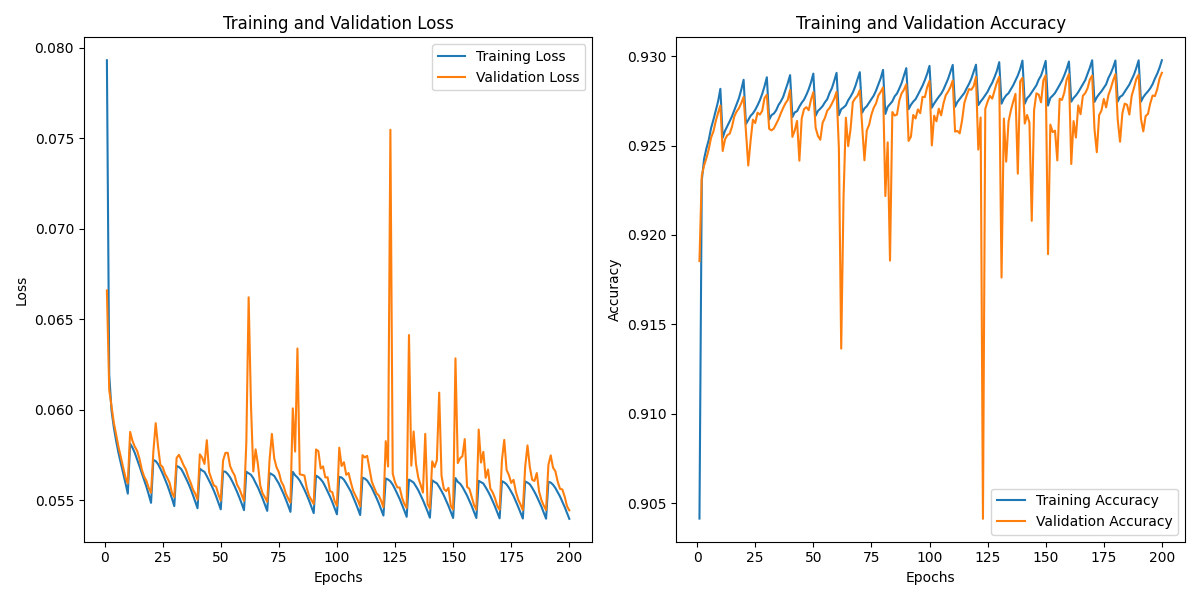

time: 381 ms


In [10]:
# save the training history of the model to csv file
history_path = os.path.join(models_dir_path, "history.csv")
pd.DataFrame.from_dict(history.history).to_csv(history_path, index=False)

# path to save the convergence curves
figure_path = os.path.join(models_dir_path, "convergence-curves.png")
plot_convergence_curves(models_dir_path, figure_path)
display(Image(filename=figure_path))

#### Evaluation on the testing dataset

Loading the model for evaluation ...
31250/31250 [==============================] - 297s 9ms/step
Accuracy: 0.929234
Classification Report saved to ../../results/gohr-random-vs-real/rounds-5/testing-statistics/classification-report.csv
Confusion Matrix:
 [[477200  22655]
 [ 48111 452034]]


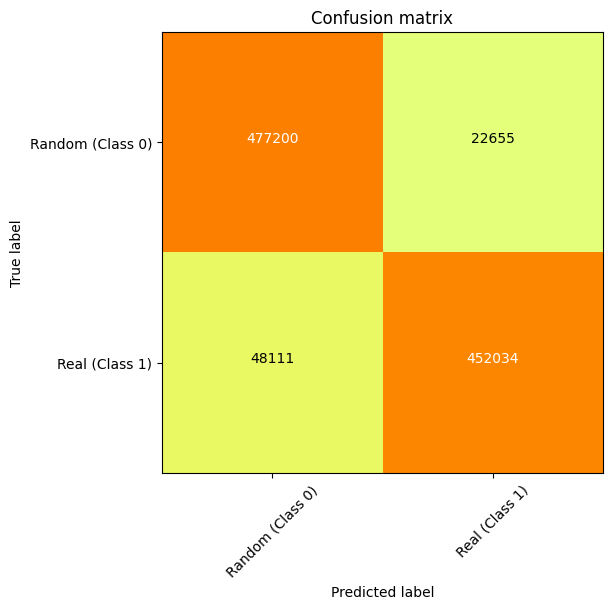

Statistics of the testing dataset are saved at location ../../results/gohr-random-vs-real/rounds-5/testing-statistics/stats.csv.


,accuracy,precision,recall,f1-score,roc-auc,tp,fp,tn,fn
0,0.929234,0.952274,0.903806,0.927407,0.975702,452034,22655,477200,48111


time: 5min 3s


In [13]:
testing_results_path = os.path.join(statistics_dir_path)
# perform evaluation on the testing dataset with the trained model
generate_evaluation_statistics(x_test, y_test, model_file_path, "testing", testing_results_path)